# Mongo

Comenzamos cargando las librerías necesarias para la realización de la misma e inicializando la conexión usando `MongoClient`.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

import pymongo
from pymongo import MongoClient

Se puede utilizar el *shell* propio de MongoDB en la máquina virtual usando el programa `mongo`. La diferencia es que ese programa espera código Javascript y aquí trabajaremos con Python.

In [6]:
!pip install --upgrade pymongo

Requirement already up-to-date: pymongo in /opt/conda/lib/python3.7/site-packages (3.10.1)


In [7]:
client = MongoClient("mongo",27017)
client

MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True)

A continuación creamos la base de datos cargándola del cliente de MongoDB, y pasamos a realizar los ejercicios propuestos.

In [8]:
db = client.stackoverflow
db

Database(MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True), 'stackoverflow')

Importación de los ficheros CSV. Por ahora creamos una colección diferente para cada uno. Después estudiaremos cómo poder optimizar el acceso usando agregación.

In [ ]:
import os
import os.path as path
from urllib.request import urlretrieve

def download_csv_upper_dir(baseurl, filename):
    file = path.abspath(path.join(os.getcwd(),os.pardir,filename))
    if not os.path.isfile(file):
        urlretrieve(baseurl + '/' + filename, file)

baseurl = 'http://neuromancer.inf.um.es:8080/es.stackoverflow/'
download_csv_upper_dir(baseurl, 'Posts.csv')
download_csv_upper_dir(baseurl, 'Users.csv')
download_csv_upper_dir(baseurl, 'Tags.csv')
download_csv_upper_dir(baseurl, 'Comments.csv')
download_csv_upper_dir(baseurl, 'Votes.csv')

Cargamos el contenido de los CSVs:

In [14]:
import csv
from datetime import datetime

def csv_to_mongo(file, coll):
    """
    Carga un fichero CSV en Mongo. file especifica el fichero, coll la colección
    dentro de la base de datos, y date_cols las columnas que serán interpretadas
    como fechas.
    """
    # Convertir todos los elementos que se puedan a números
    def to_numeric(d):
        try:
            return int(d)
        except ValueError:
            try:
                return float(d)
            except ValueError:
                return d
    
    def to_date(d):
        """To ISO Date. If this cannot be converted, return NULL (None)"""
        try:
            return datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%f")
        except ValueError:
            return None
    
    coll.drop()

    with open(file) as f:
        # La llamada csv.reader() crea un iterador sobre un fichero CSV
        reader = csv.reader(f, dialect='excel')
        
        # Se leen las columnas. Sus nombres se usarán para crear las diferentes columnas en la familia
        columns = next(reader)
        
        # Las columnas que contienen 'Date' se interpretan como fechas
        func_to_cols = list(map(lambda c: to_date if 'date' in c.lower() else to_numeric, columns))
        
        docs=[]
        for row in reader:
            row = [func(e) for (func,e) in zip(func_to_cols, row)]
            docs.append(dict(zip(columns, row)))
        coll.insert_many(docs)

In [15]:
csv_to_mongo('../Posts.csv',db.posts)

In [16]:
csv_to_mongo('../Users.csv',db.users)

In [17]:
csv_to_mongo('../Votes.csv',db.votes)

In [18]:
csv_to_mongo('../Comments.csv',db.comments)

In [19]:
csv_to_mongo('../Tags.csv',db.tags)

In [21]:
posts = db.posts

In [22]:
posts.count_documents({})

76278

Para que el proceso map-reduce y de agregación funcione mejor, voy a crear índices sobre los atributos que se usarán como índice... Ojo, si no se crea las consultas pueden tardar mucho.

In [23]:
(
    db.posts.create_index([('Id', pymongo.HASHED)]),
    db.comments.create_index([('Id', pymongo.HASHED)]),
    db.users.create_index([('Id', pymongo.HASHED)])
)

('Id_hashed', 'Id_hashed', 'Id_hashed')

## EJERCICIO: Con Map-Reduce, construir las colecciones que asocian un usuario con sus tags y los tags con los usuarios que las utilizan (E1).

En este ejercicio vamos a aplicar dos veces Map-Reduce para obtener cada una de las colecciones que pide el enunciado. Ambos procedimientos los hemos aplicado sobre la colección de posts.

Para obtener la primera de ellas, en la función *map*, extraemos los tags de cada post  aplicando las funciones `substr()` y  `split()` de javascript: primero eliminamos el primer (<) y el último (>) caracter de la cadena y a continuación separamos los diferentes tags en un array usando como delimitador '><'.

La clave que emitimos en la función `map()` es el usuario que es el propietario de ese post, mientras que los valores son los tags del post que ha escrito ese usuario. Por tanto, en la función `reduce()` lo que hacemos es recorrer los tags que le llegan y añadirlos a una misma lista de tags, uniendo así todos los tags que pertenecen al mismo usuario. Es importante remarcar, como vimos en clase, que la función `reduce()` ha de devolver los mismos valores que la función `map()`, ya que la función `reduce()` no se ejecutará si no hay más de un elemento asociado a la misma clave, y puede ocurrir que la función `reduce()` reciba valores tanto de la función `map()` como de la propia función `reduce()`. Esta lista de tags que devuelve el método `reduce()` la hemos ordenado para que en el resultado final nos salgan ordenados para cada usuario. 

Por otro lado, antes de devolver la lista ordenada, para que no nos salgan repetidos los tags que un usuario ha usado en varios posts, hemos transformado la lista de tags en un `Set` de javascript, que guarda solo los valores únicos de la lista. Ese `Set` es entonces transformado de nuevo a una lista usando el operador `...` de javascript. 

Por último, para los usuarios que no han hecho ninguna pregunta y no tienen ningún tag asociado hemos optado por mostrarlos en la colección y añadirles una lista de tags vacía. Podríamos haberlos eliminado directamente usando el modificador `query` de la función map_reduce(), como en el caso que veremos a continuación, pero hemos preferido mantenerlos en la colección y añadir una condición en la función `reduce()` para evitar que salga la cadena vacía como tag.

In [24]:
from bson.code import Code

tags_map = Code('''
function () {
  tags = this.Tags.substr(1).substr(0, this.Tags.length-2).split("><")
  emit(this.OwnerUserId, { tags: tags });
}
''')

tags_reduce = Code('''
function (key, values) {
    tags = [];
    values.forEach(function(v) {
        if (v.tags != '')
            tags = tags.concat(v.tags)
    })
    tags = [...new Set(tags)]; 
    return { tags: tags.sort() };
}
''')

db.posts.map_reduce(tags_map, tags_reduce, "user_tags")

Collection(Database(MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True), 'stackoverflow'), 'user_tags')

A continuación mostramos los diez primeros elementos de la nueva colección creada:

In [25]:
list(db.user_tags.find()[:10])

[{'_id': -1.0, 'value': {'tags': []}},
 {'_id': 20.0, 'value': {'tags': ['typescript']}},
 {'_id': 21.0,
  'value': {'tags': ['android',
    'array',
    'casting',
    'datetime',
    'delphi',
    'impresión',
    'javascript',
    'join',
    'jquery',
    'lenguaje-compilado',
    'mysql',
    'oracle',
    'oracle-10g',
    'pascal',
    'poo',
    'sobrecarga',
    'socket',
    'split',
    'sql',
    'string',
    'tcp',
    'tcpip',
    'timestamp',
    'windows']}},
 {'_id': 22.0,
  'value': {'tags': ['array',
    'atómico',
    'booleano',
    'conversión-de-tipos',
    'eventos',
    'git',
    'go',
    'javascript',
    'jquery',
    'json',
    'nodejs',
    'perl',
    'pouchdb',
    'sandbox',
    'seguridad',
    'tipos']}},
 {'_id': 23.0,
  'value': {'tags': ['.net',
    'ajax',
    'angularjs',
    'asp.net',
    'asp.net-web-api',
    'c#',
    'git',
    'google-maps',
    'jasmine',
    'javascript',
    'karma-jasmine',
    'mercurial',
    'momentjs']}},
 {'_id

El proceso seguido para mostrar los usuarios que han usado cada tag es parecido al anterior. En este caso, hemos de emitir en la función `map()` cada uno de los tags que hay presentes en el post. Para ello, recorremos la lista de tags obtenida de la aplicación de la función `split()` y emitimos cada tag con el id del propietario del post como valor. 

En la función `reduce()`, tomamos cada uno de los valores que le llegan de los *mappers* y/o *reducers* y se concatenan en una misma lista todos los usuarios correspondientes al tag en concreto. Por último, devolvemos los ids de los usuarios sin duplicados y en orden ascendente, usando de nuevo los `Sets` y la función `sort` de javascript, a la que hay que pasarle una función que indique el orden que queremos aplicar, ya que por defecto esté método ordena los elementos alfabéticamente.

Es importante mencionar sobre la función `map()` que hemos decidido eliminar los usuarios que hicieron preguntas pero no existen en la tabla users, y que se corresponden con cadenas vacías en el campo `OwnerUserId` de la tabla posts. Por ello hemos comprobado si el id del usuario es vacío cada vez que se va a emitir un tag.

Además, en este caso hemos usado el modificador `query` de `map_reduce` para quedarnos únicamente con los posts cuyos tags no fueran vacíos, eliminando así las respuestas y otros tipos de posts.

In [26]:
users_map = Code('''
function () {
  tags = this.Tags.substr(1).substr(0, this.Tags.length-2).split("><")
  OwnerUserId = this.OwnerUserId
  tags.forEach(function(tag){
      if (OwnerUserId != '')
          emit(tag, { users: [OwnerUserId] });
  })
}
''')

users_reduce = Code('''
function (key, values) {
    users = [];
    values.forEach(function(v) {
        users = users.concat(v.users)
    })
    users = [...new Set(users)]; 
    return { users: users.sort((a, b) => a - b) };
}
''')

db.posts.map_reduce(users_map, users_reduce, "tags_user", query={"Tags": {'$ne' : ''}})

Collection(Database(MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True), 'stackoverflow'), 'tags_user')

Por último mostramos los 10 primeros elementos de la colección generada:

In [27]:
list(db.tags_user.find()[:10])

[{'_id': '.asmx',
  'value': {'users': [4361.0,
    9039.0,
    9885.0,
    23683.0,
    24842.0,
    27002.0,
    43605.0]}},
 {'_id': '.htaccess',
  'value': {'users': [166.0,
    517.0,
    872.0,
    1746.0,
    2676.0,
    2770.0,
    3248.0,
    3947.0,
    4328.0,
    4530.0,
    4571.0,
    4718.0,
    5248.0,
    5438.0,
    5583.0,
    5716.0,
    6044.0,
    6046.0,
    6187.0,
    6897.0,
    7358.0,
    7498.0,
    7679.0,
    8752.0,
    9142.0,
    9254.0,
    9470.0,
    9529.0,
    9754.0,
    10365.0,
    10399.0,
    10486.0,
    10796.0,
    11342.0,
    11349.0,
    12545.0,
    13041.0,
    14025.0,
    14132.0,
    15481.0,
    15594.0,
    15653.0,
    16107.0,
    16978.0,
    18000.0,
    18031.0,
    18124.0,
    18587.0,
    18771.0,
    19419.0,
    20493.0,
    20709.0,
    21670.0,
    21882.0,
    23610.0,
    25829.0,
    25908.0,
    26657.0,
    26878.0,
    27226.0,
    27667.0,
    27826.0,
    27916.0,
    29516.0,
    29967.0,
    30152.0,
    307

## EJERCICIO: Con el Framework de Agregación, generar la colección `StackOverflowFacts` vista en la sesión 2 (E2).

En este ejercicio vamos a generar una colección en la que cada documento sea un fact diferente, ya sean posts, usuarios, votos o comentarios. Una de las ventajas que nos da Mongo es que cada documento puede tener un conjunto de atributos diferentes, lo que nos evita tener que añadir valores nulos como en el caso de SQL.

El proceso de creación de esta colección se puede resumir en los siguientes pasos:

- Primero, instanciamos un agregado de una colección cualquiera de la base de datos. Por ejemplo, posts.
- A continuación, limitamos esa colección a un único elemento y lo vaciamos, quedándonos con una colección que únicamente tiene un documento vacío.
- Es entonces cuando añadimos tantos lookups como colecciones diferentes queremos unir en la nueva colección. Al no añadir ningún valor a los campos `localField` y `foreignField`, conseguimos que se añadan las colecciones al completo. Por otro lado, hemos decidido proyectar únicamente algunos valores por colección. En el caso de los usuarios, votos y comentarios hemos añadido el id y la fecha de creación. Para posts, sin embargo, hemos incluido también el id del propietario del post y el id del tipo de pregunta, ya que los usaremos en el último ejercicio. Además, hemos añadido un string identificativo a cada colección llamado `type` que nos ayudará a comprobar que la creación de la colección ha sido correcta.
- En este punto, tenemos un agregado que consiste en un único documento que contiene cuatro arrays: uno por cada tipo de colección que hemos añadido usando `$lookup`. Para poder separar los arrays en documentos distintos de la colección hemos de realizar tres pasos. Primero, unimos los cuatro arrays usando el operador `$concatArrays`, lo que nos da un único documento con un único array conteniendo todos los documentos de las colecciones que queremos unir.
- Después, aplicamos `$unwind` para eliminar el array y obtener un único documento conteniendo todos los documentos que queremos separar. Cada uno de estos documentos tiene como clave la palabra "union".
- Por último, aplicamos el operador `$replaceRoot`, que nos permite reemplazar nuestro documento principal con todos los documentos contenidos en la unión, es decir, todos los elementos cuya clave sea "unión", lo que nos da el agregado con todos los facts como documentos. El resultado obtenido lo escribimos en una colección llamada `StackOverflowFacts` usando el operador `$out`.


In [28]:
stack_overflow_facts = db.posts.aggregate([
        { "$limit": 1 },
        { "$project": { "_id": "$$REMOVE" } },
        { "$lookup" : {
            'from': "posts", 
            'pipeline': [{ "$project" : { "PostId": "$Id", "type": "Post", "OwnerUserId": 1, "PostTypeId": 1, "CreationDate": 1 }}],
            'as': "post"}
        },
        { "$lookup" : {
            'from': "users", 
            'pipeline': [{ "$project" : { "UserId": "$Id", "type": "User", "CreationDate": 1 }}],
            'as': "user"}
        },
        
        { "$lookup" : {
            'from': "votes", 
            'pipeline': [{ "$project" : { "VoteId": "$Id", "type": "Vote", "CreationDate": 1 }}],
            'as': "vote"}
        },
        { "$lookup" : {
            'from': "comments", 
            'pipeline': [{ "$project" : { "CommentId": "$Id", "type": "Comment", "CreationDate": 1 }}],
            'as': "comment"}
        },
    
        { "$project": { "union": { "$concatArrays": ["$post", "$user", "$vote", "$comment"] } } },
        { "$unwind": "$union" },
        { "$replaceRoot": { "newRoot": '$union' } },
        { "$out": "StackOverflowFacts"}
        
])

Para comprobar que todo se ha realizado correctamente, vamos a usar la función `groupby()` de la librería `itertools` de Python para ver cuántos documentos tenemos por cada tipo de fact, y después compararlo con el número de documentos pertenecientes a cada una de las colecciones de posts, users, votes y comments de la base de datos. Como se puede observar, el número de facts de cada tipo es el mismo en ambos casos.

In [29]:
types = [x['type'] for x in list(db.StackOverflowFacts.find())]
from itertools import groupby
[len(list(group)) for key, group in groupby(types)]

[76278, 49033, 165621, 123662]

In [30]:
[db.posts.count_documents({}), db.users.count_documents({}), db.votes.count_documents({}), db.comments.count_documents({})]

[76278, 49033, 165621, 123662]

## EJERCICIO: Con Map-Reduce, implementar la consulta RQ3 de la sesión 2.

Para realizar este ejercicio, hemos considerado necesario aplicar dos veces Map-Reduce. En la primera de las aplicaciones, obtenemos por cada usuario el porcentaje de sus posts que son respuestas. 

Para ello, aplicamos la función `map_reduce()` a los posts y en la función `map()` distinguimos si el post es una pregunta o una respuesta. En ambos casos emitimos como clave el propietario de la pregunta, y como valor un objeto cuyos valores son el porcentaje de posts que son respuestas y el número de posts de ese usuario. 
Por tanto, en caso de ser una pregunta, el porcentaje de respuestas es 0, y en caso de ser una respuesta, el porcentaje es 100. En ambos casos el número de posts del usuario es 1.

Por otro lado, en la función `reduce()` aplicamos un procedimiento similar al visto en clase para obtener la puntuación media de los posts. Primero, se crean dos variables `porcentaje` y `sum` que vamos a ir actualizando. Por cada valor que le llega a la función `reduce()`, se actualiza el porcentaje sumándole el producto entre el porcentaje de ese valor y el número de posts que le corresponden, y se actualiza el número de posts sumándole el número de posts de todos los valores. Por último, para devolver el porcentaje se divide la variable `porcentaje` entre el número de posts, lo que hace que podamos obtener el porcentaje de respuestas acumulado entre todos los posts del usuario que le han llegado a la función `reduce()`.

In [31]:
porcentaje_map = Code('''
function () {
  if (this.PostTypeId == 1)
      emit(this.OwnerUserId, { porcentaje: 0, num: 1})
  else if (this.PostTypeId == 2)
      emit(this.OwnerUserId, { porcentaje: 100, num: 1})
}
''')

porcentaje_reduce = Code('''
function (key, values) {
    porcentaje = 0.0
    num = 0
    values.forEach(function(v) { 
        porcentaje += v.porcentaje*v.num
        num += v.num
    })
    return { porcentaje : porcentaje/num, num: num };
}
''')

db.posts.map_reduce(porcentaje_map, porcentaje_reduce, "porc_respuestas")

Collection(Database(MongoClient(host=['mongo:27017'], document_class=dict, tz_aware=False, connect=True), 'stackoverflow'), 'porc_respuestas')

A continuación mostramos los 20 primeros valores de la colección obtenida en el primer Map-Reduce. Hemos decidido no redondear el porcentaje porque en la siguiente aplicación del Map-Reduce vamos a dividirlos en intervalos, y no queremos que tras el redondeo algún valor caiga en un grupo que no le pertenece.

In [32]:
list(db.porc_respuestas.find()[:20])

[{'_id': 20.0, 'value': {'porcentaje': 99.4535519125683, 'num': 183.0}},
 {'_id': 21.0, 'value': {'porcentaje': 89.34426229508196, 'num': 122.0}},
 {'_id': 22.0, 'value': {'porcentaje': 36.00000000000001, 'num': 25.0}},
 {'_id': 23.0, 'value': {'porcentaje': 75.86206896551724, 'num': 29.0}},
 {'_id': 24.0, 'value': {'porcentaje': 88.37209302325581, 'num': 215.0}},
 {'_id': 25.0, 'value': {'porcentaje': 96.19883040935673, 'num': 342.0}},
 {'_id': 26.0, 'value': {'porcentaje': 100.0, 'num': 98.0}},
 {'_id': 27.0, 'value': {'porcentaje': 0.0, 'num': 1.0}},
 {'_id': 28.0, 'value': {'porcentaje': 100.0, 'num': 69.0}},
 {'_id': 29.0, 'value': {'porcentaje': 33.333333333333336, 'num': 3.0}},
 {'_id': 34.0, 'value': {'porcentaje': 95.23809523809524, 'num': 21.0}},
 {'_id': 35.0, 'value': {'porcentaje': 50.0, 'num': 6.0}},
 {'_id': 37.0, 'value': {'porcentaje': 33.333333333333336, 'num': 3.0}},
 {'_id': 39.0, 'value': {'porcentaje': 50.0, 'num': 4.0}},
 {'_id': 45.0, 'value': {'porcentaje': 98.

En este segunda aplicación del Map-Reduce lo único que nos queda por hacer es agrupar cada uno de los porcentajes en los grupos mostrados en la gráfica del apartado RQ3 del artículo y calcular el número de usuarios cuyo porcentaje de respuestas está en esos grupos.

Para agrupar los porcentajes, hemos usado la sentencia `switch` de javascript, pasándole el valor `true` para que se ejecute el primero de los casos del `switch` que sea cierto. Una vez tenemos el rango, lo emitimos como clave y añadimos 1 como valor. 

Cuando a la función `reduce()` le llegan los valores agrupados por clave, únicamente tenemos que sumarlos para contar cuántos pertenecen a cada grupo, de igual manera que en el primer ejemplo que vimos en clase.

In [33]:
rq3_map = Code('''
function () {
    rango = ''
    switch(true){
        case this.value.porcentaje == 0.0:
            rango = '0%';
            break;
        case this.value.porcentaje < 10.0:
            rango = '1-9%';
            break;
        case this.value.porcentaje < 20.0:
            rango = '10-19%';
            break;
        case this.value.porcentaje < 30.0:
            rango = '20-29%';
            break;
        case this.value.porcentaje < 40.0:
            rango = '30-39%';
            break;
        case this.value.porcentaje < 50.0:
            rango = '40-49%';
            break;
        case this.value.porcentaje < 60.0:
            rango = '50-59%';
            break;
        case this.value.porcentaje < 70.0:
            rango = '60-69%';
            break;
        case this.value.porcentaje < 80.0:
            rango = '70-79%';
            break;
        case this.value.porcentaje < 90.0:
            rango = '80-89%';
            break;
        case this.value.porcentaje < 100.0:
            rango = '90-99%';
            break;
        case this.value.porcentaje == 100.0:
            rango = '100%';
            break;
    }
    emit(rango, 1);
}
''')

rq3_reduce = Code('''
function (key, values) {
    return Array.sum(values);
}
''')

db.porc_respuestas.map_reduce(rq3_map, rq3_reduce, "porc_count")
list(db.porc_count.find())

[{'_id': '0%', 'value': 8239.0},
 {'_id': '1-9%', 'value': 124.0},
 {'_id': '10-19%', 'value': 263.0},
 {'_id': '100%', 'value': 3564.0},
 {'_id': '20-29%', 'value': 373.0},
 {'_id': '30-39%', 'value': 367.0},
 {'_id': '40-49%', 'value': 119.0},
 {'_id': '50-59%', 'value': 774.0},
 {'_id': '60-69%', 'value': 223.0},
 {'_id': '70-79%', 'value': 152.0},
 {'_id': '80-89%', 'value': 164.0},
 {'_id': '90-99%', 'value': 142.0}]

Como se puede observar en la salida anterior, el resultado queda ordenado alfabéticamente por el campo `_id`. Por ello, el caso correspondiente al 100% queda el cuarto en la lista. Para ponerlo el último y obtener una gráfica como la de SQL, lo eliminamos de esa posición y lo añadimos al final.

In [34]:
porcentajes = list(db.porc_count.find())
porcentajes.append(porcentajes.pop(3))
porcentajes

[{'_id': '0%', 'value': 8239.0},
 {'_id': '1-9%', 'value': 124.0},
 {'_id': '10-19%', 'value': 263.0},
 {'_id': '20-29%', 'value': 373.0},
 {'_id': '30-39%', 'value': 367.0},
 {'_id': '40-49%', 'value': 119.0},
 {'_id': '50-59%', 'value': 774.0},
 {'_id': '60-69%', 'value': 223.0},
 {'_id': '70-79%', 'value': 152.0},
 {'_id': '80-89%', 'value': 164.0},
 {'_id': '90-99%', 'value': 142.0},
 {'_id': '100%', 'value': 3564.0}]

A continuación mostramos la gráfica correspondiente a la resolución del ejercicio RQ3.

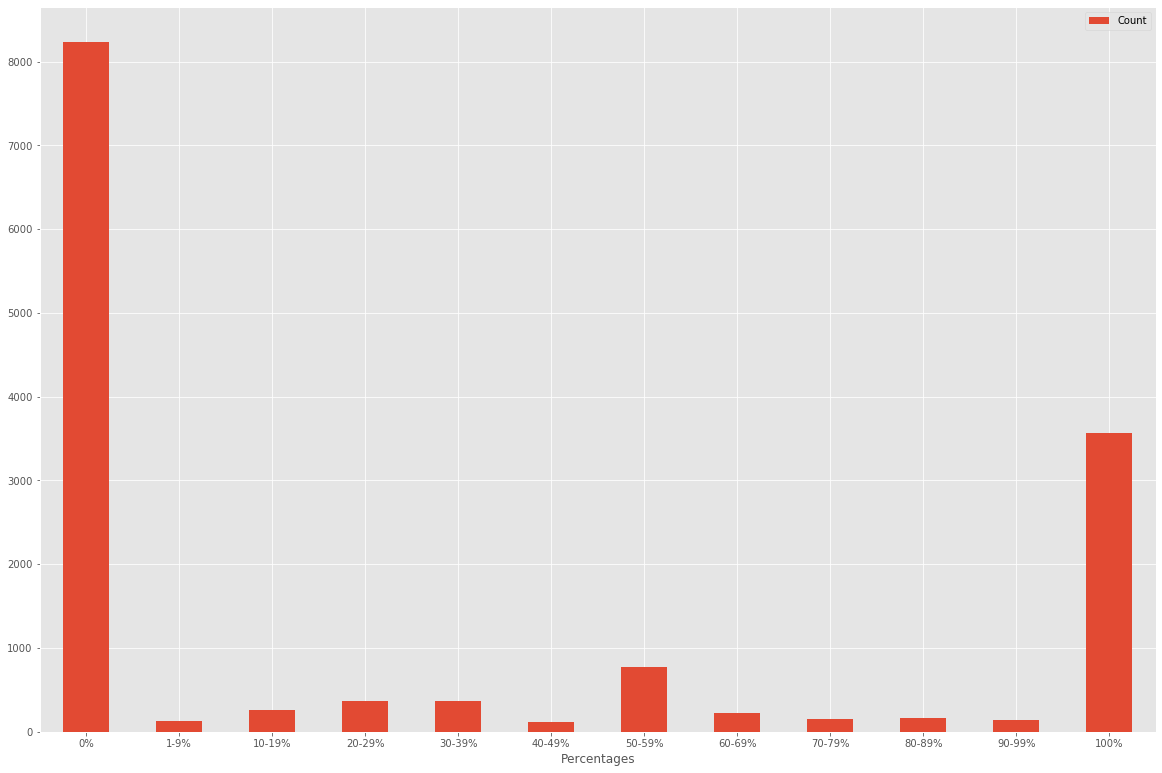

In [35]:
df = pd.DataFrame(porcentajes)
df.columns = ['Percentages', 'Count']
df.plot(x='Percentages', y='Count', kind='bar', figsize=(20,20*2/3), rot=0)

## EJERCICIO (difícil, opcional): Con Agregación, calcular, en la tabla `StackOverflowFacts` la media de tiempo que pasa desde que los usuarios se registran hasta que publican su primera pregunta.

Para la realización de este ejercicio hemos seguido los siguientes pasos:

- Primero, creamos un agregado sobre la colección `StackOverflowFacts`, y nos quedamos solo con aquellos facts que tengan el campo `PostTypeId` igual a 1 (las preguntas). 
- A continuación, agrupamos las preguntas por `OwnerUserId` y nos quedamos con la mínima, la que se realizara antes.
- Para poder calcular la diferencia de tiempo, hemos de aplicar el operador `$lookup` para unir cada una de las preguntas con el usuario que la creó. 
- Después, para eliminar el array que contiene al usuario que se crea por cada pregunta al aplicar el `$lookup`, usamos el operador `$unwind`.
- Una vez tenemos cada pregunta con su usuario en el mismo documento, nos quedamos únicamente con su `_id`, la fecha de creación de la pregunta y la diferencia entre esa fecha y la fecha de creación del usuario.
- Por último, solo tenemos que calcular la media a todas las diferencias obtenidas en el paso anterior. Para ello, podemos aplicar el operador `$group`, el cual, si le pasamos el parámetro `_id` con valor `None`, aplica la media sobre la variable especificada en toda la colección. Una vez obtenida la media hemos aplicado el operador `$divide` sobre ella para que nos devuelva el resultado en segundos en lugar de en milisegundos, de igual manera que en la práctica de SQL.

Comparando el resultado con SQL, hemos constatado de que se trata del mismo valor, excepto por algunos decimales.

Dado que estamos aplicando el operador `$lookup` sobre la colección `StackOverflowFacts` consigo misma, esta consulta tarda mucho tiempo si no añadimos un índice sobre el atributo que se pasa como `foreignField` al `lookup`:



In [36]:
db.StackOverflowFacts.create_index([('UserId', pymongo.HASHED)])

'UserId_hashed'

In [37]:
min_reg_question_time = db.StackOverflowFacts.aggregate([
        {"$match" : {"PostTypeId" : 1}},
        {
            '$group' : {'_id' : '$OwnerUserId',
                        'min' : {'$min' : "$CreationDate"}
                        }
        },
        { "$lookup" : {
            'from': "StackOverflowFacts", 
            'localField': "_id",
            'foreignField': "UserId",
            'as': "user"}
        },
        { "$unwind" : "$user"},
        { "$project" : {
            "_id" : True,
            "min" : True,
            "diff" : {"$subtract" : ["$min", "$user.CreationDate"]}
            }
        },
        {
            "$group" :  {
                "_id" : None,
                "avg" : { "$avg" : "$diff" }
            }
        },
        {
            "$project" : {
                "_id" : 0,
                "media" : { "$divide" : ["$avg", 1000]}
            }
        }
])
min_reg_question_time = list(min_reg_question_time)
min_reg_question_time

[{'media': 1536940.0048161624}]